<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>
Final Project - Machine Learning Short Term Stock Movements in<br><br> Prices with A2M.AX</p><br>
<br>
The aim of this project is to answer the following question:

**With the help of daily stock data and machine learning tools, are we able to predict short term future prices of stock?**

The reason for this investigation is that I've always been curious about whether future stock prices can be predicted with any accuracy whatsoever using historical time series data. 

The dataset used is from Yahoo Finance. It contains 1,180 data samples of daily stock data for the stock A2M.AX, listed on the ASX. The data range is from 31 March 2015 to 22 November 2019. 

You can obtain similar data yourself by creating a proile on Yahoo Finance, and adding whatever stock or stocks you're interested to your portfolio, then exporting the data using csv format.

Location: https://finance.yahoo.com/

In [101]:
%config IPCompleter.greedy=True

# Below can be used to change the width of the Jupyter notebook. I did this so that the full dataset with all variables can be seen without needing to 
# use the scrollbar

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

Let's load our data in to the notebook and check out a few key features of it to get an idea how it's shaped and how it looks.

In [103]:
data = pd.read_csv('A2M-ASX.csv')

In [104]:
print(data.shape)
[x for x in data.columns]

(1180, 26)


['date',
 'open',
 'high',
 'low',
 'close',
 'adj_close',
 'range',
 'range_change',
 'range_move',
 'price_change',
 'tomo_price_move',
 'volume',
 'qty_change',
 'qty_move',
 '5d_avg_range',
 'change_in_5d_avg_range',
 '5d_avg_range_move',
 '5d_avg_px',
 'change_in_5d_avg_px',
 '5d_avg_px_move',
 '5d_avg_qty',
 'change_in_5d_avg_qty',
 '5d_avg_qty_move',
 '10d_avg_px',
 'change_in_10d_avg_px',
 '10d_avg_px_move']

Off the bat we can see how many features each data sample has, and what these features are. As can be seen, it's a mixture of price and volume data for daily intervals.

Let's view some of the data.

In [105]:
data[:10]

,date,open,high,low,close,adj_close,range,range_change,range_move,price_change,...,5d_avg_range_move,5d_avg_px,change_in_5d_avg_px,5d_avg_px_move,5d_avg_qty,change_in_5d_avg_qty,5d_avg_qty_move,10d_avg_px,change_in_10d_avg_px,10d_avg_px_move
0,3/31/2015,0.555,0.595,0.530,0.565,0.565,0.065,NaN,Flat,0.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4/1/2015,0.575,0.580,0.555,0.565,0.565,0.025,-0.040,Down,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4/2/2015,0.560,0.565,0.535,0.555,0.555,0.030,0.005,Up,-0.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4/7/2015,0.545,0.550,0.540,0.545,0.545,0.010,-0.020,Down,-0.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4/8/2015,0.545,0.545,0.530,0.540,0.540,0.015,0.005,Up,-0.005,...,NaN,0.554,NaN,NaN,2606643.8,NaN,NaN,NaN,NaN,NaN
5,4/9/2015,0.540,0.540,0.532,0.535,0.535,0.008,-0.007,Down,-0.005,...,Down,0.548,-0.006,Down,1784754.2,-821889.6,Down,NaN,NaN,NaN
6,4/10/2015,0.530,0.535,0.530,0.535,0.535,0.005,-0.003,Down,0.000,...,Down,0.542,-0.006,Down,944443.0,-840311.2,Down,NaN,NaN,NaN
7,4/13/2015,0.535,0.540,0.530,0.540,0.540,0.010,0.005,Up,0.005,...,Down,0.539,-0.003,Down,501676.6,-442766.4,Down,NaN,NaN,NaN
8,4/14/2015,0.540,0.540,0.535,0.540,0.540,0.005,-0.005,Down,0.000,...,Down,0.538,-0.001,Down,497519.4,-4157.2,Down,NaN,NaN,NaN
9,4/15/2015,0.540,0.550,0.540,0.540,0.540,0.010,0.005,Up,0.000,...,Down,0.538,0.000,Flat,548980.0,51460.6,Up,0.546,NaN,NaN


Immediately we can see there are a number of NaN values. These will need dealing with. 

Let's view them all first to see why they are there and if we should simply removing or altering to another value.

In [106]:
nulls = data.isnull().any(axis=1)
data[nulls]

,date,open,high,low,close,adj_close,range,range_change,range_move,price_change,...,5d_avg_range_move,5d_avg_px,change_in_5d_avg_px,5d_avg_px_move,5d_avg_qty,change_in_5d_avg_qty,5d_avg_qty_move,10d_avg_px,change_in_10d_avg_px,10d_avg_px_move
0,3/31/2015,0.555,0.595,0.530,0.565,0.565,0.065,NaN,Flat,0.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4/1/2015,0.575,0.580,0.555,0.565,0.565,0.025,-0.040,Down,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4/2/2015,0.560,0.565,0.535,0.555,0.555,0.030,0.005,Up,-0.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4/7/2015,0.545,0.550,0.540,0.545,0.545,0.010,-0.020,Down,-0.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4/8/2015,0.545,0.545,0.530,0.540,0.540,0.015,0.005,Up,-0.005,...,NaN,0.554,NaN,NaN,2606643.8,NaN,NaN,NaN,NaN,NaN
5,4/9/2015,0.540,0.540,0.532,0.535,0.535,0.008,-0.007,Down,-0.005,...,Down,0.548,-0.006,Down,1784754.2,-821889.6,Down,NaN,NaN,NaN
6,4/10/2015,0.530,0.535,0.530,0.535,0.535,0.005,-0.003,Down,0.000,...,Down,0.542,-0.006,Down,944443.0,-840311.2,Down,NaN,NaN,NaN
7,4/13/2015,0.535,0.540,0.530,0.540,0.540,0.010,0.005,Up,0.005,...,Down,0.539,-0.003,Down,501676.6,-442766.4,Down,NaN,NaN,NaN
8,4/14/2015,0.540,0.540,0.535,0.540,0.540,0.005,-0.005,Down,0.000,...,Down,0.538,-0.001,Down,497519.4,-4157.2,Down,NaN,NaN,NaN
9,4/15/2015,0.540,0.550,0.540,0.540,0.540,0.010,0.005,Up,0.000,...,Down,0.538,0.000,Flat,548980.0,51460.6,Up,0.546,NaN,NaN


We see that the null data is only our data which contains averages for preceding days, as these data points don't have enough previous days to average. The last row is also NaN as it is missing a value for 'tomo_price_move' as the next day's price wasn't known the time this data was created.

Let's remove these data points as they shouldn't affect our end results too much, and there's no other way to know what these data points should be without digging for more data.

In [107]:
data = data.dropna()
print(data.shape)
data.head()

(1169, 26)


,date,open,high,low,close,adj_close,range,range_change,range_move,price_change,...,5d_avg_range_move,5d_avg_px,change_in_5d_avg_px,5d_avg_px_move,5d_avg_qty,change_in_5d_avg_qty,5d_avg_qty_move,10d_avg_px,change_in_10d_avg_px,10d_avg_px_move
10,4/16/2015,0.545,0.545,0.525,0.53,0.53,0.020,0.010,Up,-0.01,...,Up,0.537,-0.001,Down,526133.4,-22846.6,Down,0.5425,-0.0035,Down
11,4/17/2015,0.525,0.540,0.520,0.54,0.54,0.020,0.000,Flat,0.01,...,Up,0.538,0.001,Up,600670.6,74537.2,Up,0.5400,-0.0025,Down
12,4/20/2015,0.535,0.535,0.520,0.52,0.52,0.015,-0.005,Down,-0.02,...,Up,0.534,-0.004,Down,562333.0,-38337.6,Down,0.5365,-0.0035,Down
13,4/21/2015,0.525,0.530,0.520,0.52,0.52,0.010,-0.005,Down,0.00,...,Up,0.530,-0.004,Down,618294.0,55961.0,Up,0.5340,-0.0025,Down
14,4/22/2015,0.520,0.530,0.520,0.52,0.52,0.010,0.000,Flat,0.00,...,Flat,0.526,-0.004,Down,511622.2,-106671.8,Down,0.5320,-0.0020,Down


Let's check if our data is Pandas datetime format so we can actually predict using it.

In [108]:
data.dtypes

date                       object
open                      float64
high                      float64
low                       float64
close                     float64
adj_close                 float64
range                     float64
range_change              float64
range_move                 object
price_change              float64
tomo_price_move            object
volume                      int64
qty_change                float64
qty_move                   object
5d_avg_range              float64
change_in_5d_avg_range    float64
5d_avg_range_move          object
5d_avg_px                 float64
change_in_5d_avg_px       float64
5d_avg_px_move             object
5d_avg_qty                float64
change_in_5d_avg_qty      float64
5d_avg_qty_move            object
10d_avg_px                float64
change_in_10d_avg_px      float64
10d_avg_px_move            object
dtype: object

We confirm the `date` column is the generic object type which could be a string. Since we want to perform time related actions on this data, we need to convert it to a datetime format before it can be useful to us. Let’s go ahead and do this using the `.to_datetime()` method.

By checking dtype again we confirm the date is now datetime format.

In [109]:
data['date'] = pd.to_datetime(data['date'])
data.dtypes

date                      datetime64[ns]
open                             float64
high                             float64
low                              float64
close                            float64
adj_close                        float64
range                            float64
range_change                     float64
range_move                        object
price_change                     float64
tomo_price_move                   object
volume                             int64
qty_change                       float64
qty_move                          object
5d_avg_range                     float64
change_in_5d_avg_range           float64
5d_avg_range_move                 object
5d_avg_px                        float64
change_in_5d_avg_px              float64
5d_avg_px_move                    object
5d_avg_qty                       float64
change_in_5d_avg_qty             float64
5d_avg_qty_move                   object
10d_avg_px                       float64
change_in_10d_av

Let's also index by date to explore the data. We do this using the `.set_index()` method.

In [111]:
data = data.set_index('date')

In [112]:
data.head()

,open,high,low,close,adj_close,range,range_change,range_move,price_change,tomo_price_move,...,5d_avg_range_move,5d_avg_px,change_in_5d_avg_px,5d_avg_px_move,5d_avg_qty,change_in_5d_avg_qty,5d_avg_qty_move,10d_avg_px,change_in_10d_avg_px,10d_avg_px_move
date,,,,,,,,,,,,,,,,,,,,,
2015-04-16,0.545,0.545,0.525,0.53,0.53,0.020,0.010,Up,-0.01,Up,...,Up,0.537,-0.001,Down,526133.4,-22846.6,Down,0.5425,-0.0035,Down
2015-04-17,0.525,0.540,0.520,0.54,0.54,0.020,0.000,Flat,0.01,Down,...,Up,0.538,0.001,Up,600670.6,74537.2,Up,0.5400,-0.0025,Down
2015-04-20,0.535,0.535,0.520,0.52,0.52,0.015,-0.005,Down,-0.02,Flat,...,Up,0.534,-0.004,Down,562333.0,-38337.6,Down,0.5365,-0.0035,Down
2015-04-21,0.525,0.530,0.520,0.52,0.52,0.010,-0.005,Down,0.00,Flat,...,Up,0.530,-0.004,Down,618294.0,55961.0,Up,0.5340,-0.0025,Down
2015-04-22,0.520,0.530,0.520,0.52,0.52,0.010,0.000,Flat,0.00,Down,...,Flat,0.526,-0.004,Down,511622.2,-106671.8,Down,0.5320,-0.0020,Down


When plotting, as can be seen, given that we are doing time series, time is on the x axis and the y axis contains the magnitude of the data. By plotting the price data we can see change in price over time. 

Notice how the date column was used as our x-axis and because we had previously casted our date column to datetime, the graph was plotted in half yearly intervals.

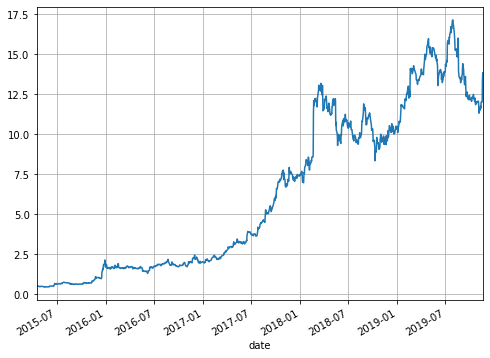

In [113]:
data['adj_close'].plot(grid=True, figsize=(8, 6))

Now that our data is clean, lets's find some more interesting aspects of our data. 

Using Panda's `.describe()` method we can analyse basic statistical properties of the data set. Note this only works for numerical data.

Given the length of the data, and the change of A2M.AX over time, this is not very useful for basic price data, but is more interesting for range and volume data, as well as averaged price data.

In [125]:
data.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
open,1169.0,6.32,5.06,0.47,1.74,4.22,10.94,17.20
high,1169.0,6.41,5.13,0.48,1.76,4.28,11.14,17.30
low,1169.0,6.22,4.99,0.46,1.72,4.15,10.80,17.03
close,1169.0,6.31,5.06,0.46,1.74,4.23,10.97,17.13
adj_close,1169.0,6.31,5.06,0.46,1.74,4.23,10.97,17.13
range,1169.0,0.19,0.19,0.00,0.04,0.13,0.29,2.08
range_change,1169.0,0.00,0.14,-1.42,-0.04,-0.00,0.04,1.20
price_change,1169.0,0.01,0.22,-2.11,-0.05,0.00,0.06,2.59
volume,1169.0,4850434.12,5403130.18,0.00,2226168.00,3501875.00,5363882.00,61397295.00
qty_change,1169.0,4556.46,4973510.84,-41366403.00,-1186807.00,-113648.00,1031337.00,41677409.00


I feel like range change may be a useful indicator but lets continue investigating. 

## Simple Classification


Let's start with a simple classification. For each data sample, we will try to classify tomorrow's price movement (be it up, down or flat).

We must first define our features, and then the target. For features let's use everything except 'tomo_price_move' which will be our target.

In [160]:
features = ['open', 'high', 'low', 'close', 'adj_close', 'range', 'range_change', 'range_move', 'price_change', 'volume', \
            'qty_change', 'qty_move', '5d_avg_range', 'change_in_5d_avg_range', '5d_avg_range_move', '5d_avg_px', 'change_in_5d_avg_px', \
            '5d_avg_px_move', '5d_avg_qty', 'change_in_5d_avg_qty', '5d_avg_qty_move', '10d_avg_px', 'change_in_10d_avg_px', '10d_avg_px_move']

target = ['tomo_price_move']

Remember we are using the daily stock data (f(x)) to come up with a predictor for tomorrow's stock price movement (y).

In [162]:
x = data[features].copy()
y = data[target].copy()

In [163]:
x.columns

Index(['open', 'high', 'low', 'close', 'adj_close', 'range', 'range_change',
       'range_move', 'price_change', 'volume', 'qty_change', 'qty_move',
       '5d_avg_range', 'change_in_5d_avg_range', '5d_avg_range_move',
       '5d_avg_px', 'change_in_5d_avg_px', '5d_avg_px_move', '5d_avg_qty',
       'change_in_5d_avg_qty', '5d_avg_qty_move', '10d_avg_px',
       'change_in_10d_avg_px', '10d_avg_px_move'],
      dtype='object')

In [164]:
y.columns

Index(['tomo_price_move'], dtype='object')

Our labels in our `tomo_price_move` target are "Up", "Down" and "Flat". These will need changing to numbers in order for our model to correctly train. Data in our features containing the same labels will also need changing to numbers.

Let's map as below:

    Up - 1
    Down - 0
    Flat - 2

In [197]:
y.replace("Up", 1, inplace=True)
y.replace("Down", 0, inplace=True)
y.replace("Flat", 0.5, inplace=True)

x.replace("Up", 1, inplace=True)
x.replace("Down", 0, inplace=True)
x.replace("Flat", 0.5, inplace=True)

y.head()

,tomo_price_move
date,
2015-04-16,1.0
2015-04-17,0.0
2015-04-20,2.0
2015-04-21,2.0
2015-04-22,0.0


## Let's perform our Training and Test data split

### REMINDER: Training Phase

In the `training phase`, the learning algorithm uses the training data to adjust the model’s parameters to minimize errors.  At the end of the training phase, you get the trained model.

In the `testing phase`, the trained model is applied to test data.  Test data is separate from the training data, and is previously unseen by the model.  The model is then evaluated on how it performs on the test data.  The goal in building a classifier model is to have the model perform well on training as well as test data.

From sklearn.model_selection let's use the `train_test_split()` function to split our datasets in to training and test subsets. It takes in arguments of 2 dataframes (x, y), and returns 4 dataframes (x_train, x_test, y_train, y_test).

In [199]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=369)

## Now that our data's split, let's fit the training data

Below we are trying to fit the model on to the training dataset. Let's start with a `Decision Tree Classifier`. From sklearn.tree we import and use DecisionTreeClassifier().

In [200]:
px_movement_classifier = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)

We then fit our classifier using it's `.train(x_train, y_train)` method.

In [201]:
px_movement_classifier.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

By checking our most important features of our classifier, we can see that only 6 features of our original 24 features have been assigned weight. The rest are 0! We may need to rethink about the features of our model..

Regardless, let's see how the model performs on our test set.

In [202]:
px_movement_classifier.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.1061551 , 0.        , 0.        , 0.25361331,
       0.        , 0.        , 0.        , 0.17071644, 0.        ,
       0.        , 0.27187209, 0.        , 0.        , 0.10109788,
       0.        , 0.09654518, 0.        , 0.        ])

In [225]:
px_movement_classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

## Predicting on our test set

We use the `.predict()` method of the DecisionTreeClassifier object to predict y values on our unseen x_test data. We are asking our decision tree classifier model to predict on the test set which it has not see at all during its training. 

The returned value is a vector of our model's predictions of stock price movement for the following day. (0 for down, 1 for up, 2 for flat). We store this in variable 'predictions'.

In [212]:
predictions = px_movement_classifier.predict(x_test)

Below we see the first 10 predicitons of our model on the x test data for y, and then compare it to the actual test data labels for y. Remember our predictions are the predicted stock price movement for the following day on what the model learned from the training set.

We can see that our predicions are fairly **innaccurate**, with 3 out of 10 being correct. An error has occured for 7 out of the 10 labels. This is when the model's prediction of the class label is different to the true class label.

In [224]:
predictions[:10]

array([0., 0., 0., 1., 1., 0., 1., 0., 0., 0.])

In [218]:
y_test['tomo_price_move'][:10]

date
2016-11-21    1.0
2018-10-10    0.0
2016-05-10    1.0
2016-09-28    2.0
2015-06-10    1.0
2019-02-04    1.0
2017-12-01    0.0
2018-09-14    1.0
2019-07-24    1.0
2019-06-19    0.0
Name: tomo_price_move, dtype: float64

## Let's measure the accuracy of our decision tree classifier 

From sklearn.metrics we can import and use the `accuracy_score(y_true, y_pred)` function. This allows us to test the accuracy of our classifier. The arguments are as below:

y_true : 1d array-like, Ground truth (correct) labels.

y_pred : 1d array-like, Predicted labels, as returned by a classifier.

In [226]:
accuracy_score(y_true=y_test, y_pred=predictions).round(4)

0.4615

Our accuracy for this classifier is only 46%, which is hardly better than guessing given that the price is unlikely to be flat (especially as the price rises higher).

## Let's see if using autocorrelation we can get more fruitful results.

The autocorrelation formula is below. We can check this to verify we're getting what we want. It represents the `autocorrelation function at lag k`.

![image](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR07iiMJJYdDztMGGrem2CSdBJ4V3g4MsBM-TEoaxBiZZJ6iwjy)

To calculate autocorrelation lets import the autocorrelation function `acf` from `statsmodels`:

**Note: We do not use Panda's `.autocorr()` funtion as it returns the Pearson Correlation Coefficient rather than the Autocorrelation.**

`acf` uses the overall series sample mean and sample variance to determine the correlation coefficient (formula above). 

Pearsons Correlation Coefficient on the other hand uses sample mean and sample variance of each subseries to determine the correlation coefficient (formula below).

![image](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRJTFuwQcRWmiVf_N16MgP_-HY64lP5P0B0natLUk1L4CbuCy3f)

In [496]:
from statsmodels.tsa.stattools import acf
?acf

As per the documentation - `acf(array, nlags=40)` returns the autocorrelation function for 1d arrays. 

The `nlags` optional argument specifies the number of lags to return autocorrelation for. The result is returned in an array. For given nlags = k, the array of acf returned is for k and smaller lags, iterating by 1 to 0.

Panda's dataframe method `.rolling(window)` provides rolling window calculations. We will use this for calculating autocorrelation for each data point.

In [497]:
rng_data = data['range']

print(rng_data[-20:])

auto_test = rng_data.rolling(4).apply(lambda x: acf(x, nlags=1)[1].round(4), raw=False)
auto_test[-20:]

date
2019-10-25    0.250
2019-10-28    0.140
2019-10-29    0.160
2019-10-30    0.150
2019-10-31    0.110
2019-11-01    0.110
2019-11-04    0.130
2019-11-05    0.360
2019-11-06    0.515
2019-11-07    0.390
2019-11-08    0.370
2019-11-11    0.220
2019-11-12    0.265
2019-11-13    0.350
2019-11-14    0.735
2019-11-15    0.245
2019-11-18    0.280
2019-11-19    1.010
2019-11-20    0.450
2019-11-21    0.325
Name: range, dtype: float64


date
2019-10-25   -0.2889
2019-10-28    0.1028
2019-10-29    0.2321
2019-10-30   -0.2240
2019-10-31   -0.0714
2019-11-01    0.2861
2019-11-04   -0.2045
2019-11-05   -0.0203
2019-11-06    0.2850
2019-11-07    0.0811
2019-11-08   -0.4153
2019-11-11    0.0641
2019-11-12    0.1733
2019-11-13   -0.2935
2019-11-14    0.0779
2019-11-15   -0.3922
2019-11-18   -0.3300
2019-11-19   -0.2156
2019-11-20   -0.2142
2019-11-21   -0.4014
Name: range, dtype: float64

In [471]:
acf(autocorr_test, nlags=1)[1]

0.5000000000000001

In [318]:
data['range'][:20]

date
2015-04-16    0.020
2015-04-17    0.020
2015-04-20    0.015
2015-04-21    0.010
2015-04-22    0.010
2015-04-23    0.010
2015-04-24    0.020
2015-04-27    0.010
2015-04-28    0.025
2015-04-29    0.010
2015-04-30    0.025
2015-05-01    0.005
2015-05-04    0.010
2015-05-05    0.010
2015-05-06    0.005
2015-05-07    0.015
2015-05-08    0.010
2015-05-11    0.010
2015-05-12    0.030
2015-05-13    0.035
Name: range, dtype: float64